In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from toolbox.image import img_scale
pixscale = 0.168 # arcsec/pixel
plt.style.use('jpg')

In [2]:
imDIR = '../data/gemini_FT_6-2016/'
c6files = os.listdir(imDIR+'candy_6_cutout')
c6files[1], c6files[2] = c6files[2], c6files[1]
c6files.reverse() # imshow expects RGB
c7files = os.listdir(imDIR+'candy_7_cutout')
c7files[1], c7files[2] = c7files[2], c7files[1]
c7files.reverse()
profDIR = '../data/post_stamp_profiles/'
prof6 = np.loadtxt(profDIR+'candy_6_prof_i.dat')
prof7 = np.loadtxt(profDIR+'candy_7_prof_i.dat')

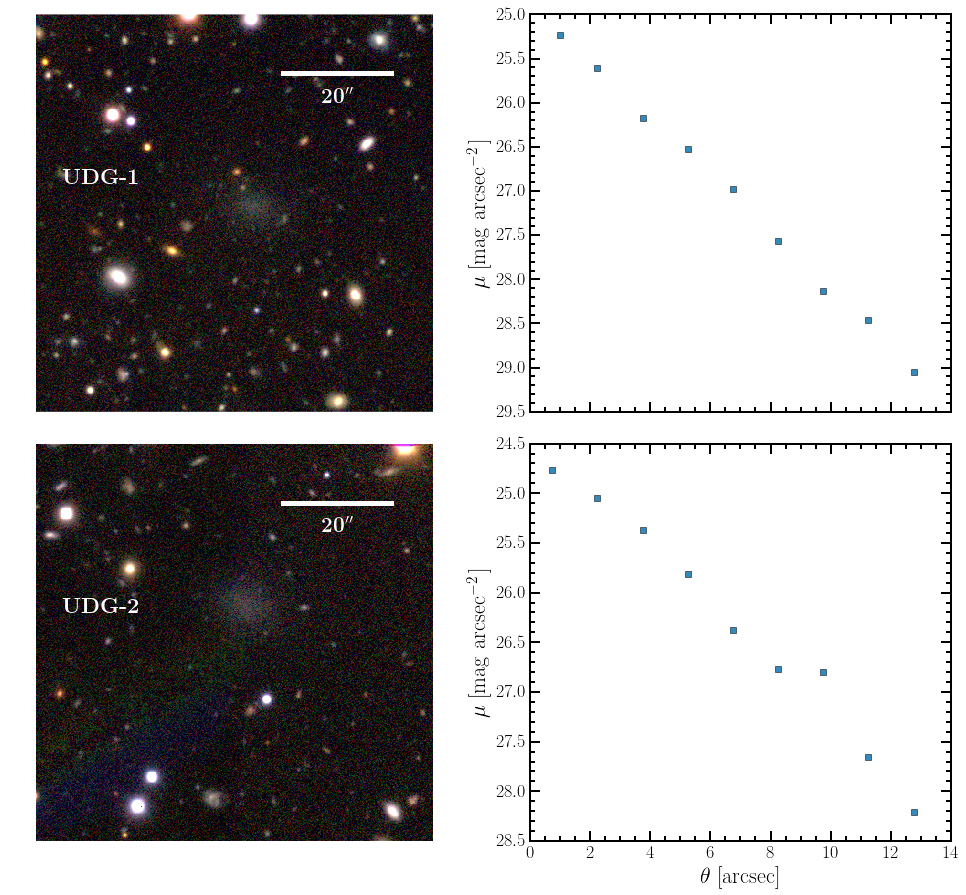

In [3]:
c6 = np.zeros((444, 437, 3))
c7 = np.zeros((451, 463, 3))
c6_max_vals = [0.5, 1.2, 1.9]
c7_max_vals = [0.7, 2.0, 1.2]
min_val = 0.0
for i in range(len(c6files)-1):
    c6_data = fits.getdata(imDIR+'candy_6_cutout/'+c6files[i])
    c7_data = fits.getdata(imDIR+'candy_7_cutout/'+c7files[i])
    max_val = c6_data.mean() + c6_max_vals[i]*c6_data.std()
    c6[:,:,i] = img_scale.sqrt(c6_data, scale_min=min_val, scale_max=max_val)
    max_val = c7_data.mean() + c7_max_vals[i]*c7_data.std()
    c7[:,:,i] = img_scale.sqrt(c7_data, scale_min=min_val, scale_max=max_val)
f, ax = plt.subplots(2, 2, figsize=(16,14))
f.subplots_adjust(hspace=0.08)
c6 = c6[:435, :435, :] 
c7 = c7[:435, :435, :] 
y = 370.
xmin = 270.
xmax = xmin + 119
for i, c, p in zip(range(2), [c6, c7], [prof6, prof7]):
    ax[i,0].imshow(c, aspect='equal', origin='lower')
    ax[i,0].axhline(y=y, xmin=xmin/c.shape[1], 
                  xmax=xmax/c.shape[1], color='w', lw=5, zorder=10)
    ax[i,0].text(0.5*(xmin+xmax), y-31.5, r'${\bf 20^{\prime\prime}}$', 
                 color='w',fontsize=21, ha='center')
    ax[i,0].text(28, 250, r'\textbf{UDG-'+str(i+1)+'}', 
                 fontsize=22, color='w', fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].plot(p[:-1,0], 27 - 2.5*np.log10(p[:-1,1]), 's')
    ax[i,1].invert_yaxis()
    ax[i,1].minorticks_on()
    ax[i,1].set_ylabel(r'$\mu$ [mag arcsec$^{-2}\,$]')
ax[1,1].set_xlabel(r'$\theta$ [arcsec]')
plt.setp(ax[0,1].get_xticklabels(), visible=False);